# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
import sys
import os
import json
from glob import glob
from collections import OrderedDict, defaultdict

import skimage
import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.datasets as dset
import torchvision.transforms as transforms


! pip install ftfy regex tqdm
!git clone https://github.com/eladgsofer/DeepKeep.git
GIT_PATH = '/content/DeepKeep'
sys.path.append(GIT_PATH)

import clip

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 1.6 MB/s eta 0:00:00
Cloning into 'DeepKeep'...
remote: Enumerating objects: 257, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 257 (delta 125), reused 110 (delta 110), pack-reused 100 (from 1)
Receiving objects: 100% (257/257), 8.89 MiB | 34.22 MiB/s, done.
Resolving deltas: 100% (139/139), done.


In [2]:
assert torch.__version__.split(".") >= ["1", "7", "1"], "PyTorch 1.7.1 or later is required"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Tagger Class

In [3]:
class ClipTagger(torch.nn.Module):
  """
  A custom module for tag-based image classification using the CLIP model.

  ClipTagger classifies images by predicting the most likely value for a set of predefined queries (e.g., 'location')
  and their possible values (e.g., ['indoor', 'outdoor']). It uses an entropy threshold to
  filter out uncertain predictions, returning a list of predictions for each image.

    Parameters:
  -----------
  tag_dict : dict
      A dictionary mapping each query to a list of possible values.
      Example: {'location': ['indoor', 'outdoor'], 'dominant_color': ['blue', 'red', 'green']}.

  entropy_threshold : float
      A threshold value used to filter out uncertain predictions based on entropy.

  clip_ver : str, optional
      The version of the CLIP model to use. Default is "ViT-B/32".

  caption_format : str, optional
      A format string for generating captions for prompt engineering.
      Default is "the picture {0} is {1}", where {0} will be replaced by the query
      and {1} by the corresponding value.
  """


  # An issue regarding inheritence directly from CLIP
  def __init__(self, tag_dict, entropy_threshold, clip_ver="ViT-B/32", caption_format="the picture {0} is {1}"):
    super().__init__()

    self.clip_model, self.clip_preprocess = clip.load(clip_ver)
    self.entropy_threshold = entropy_threshold
    self.tag_dict = tag_dict
    self.caption_format = caption_format

    self.query_cap_map = {}  # Maps queries to generated captions
    self.query_token_map = {}  # Maps queries to tokenized text
    self.query_emb_map = {}  # Maps queries to their embeddings
    self.idx_label_map = defaultdict(dict)  # Maps values (labels) indices to their text for each query

    self.init_tagger_mappers(self.tag_dict)

  def init_tagger_mappers(self, tag_dict=None):
    """
    Initializes four dictionaries to enhance the efficiency of inference and
    training by pre-computing the text tokens and embeddings for the queries in tag_dict.
    Since ClipTagger classifies the images using the same set of queries for each image,
    this approach prevents redundant computation of the text embeddings over and over.

    ### NOTE: After training, call this function to reinitialize `self.query_emb_map`
    dictionary with updated embeddings, as changes in the encoder parameters will modify
    the embeddings. ###

    Parameters:
      -----------
      tag_dict : dict
          A dictionary mapping each query to a list of possible values.
          a tag_dict is in the following format: {query0: [value0, value1,...]}
          for example tag_dict = {'location': ['indoor', 'outdoor']}

    This method should be called if the tagger's queries need to be re-initialized or modified.
    """

    if tag_dict:
      self.tag_dict = tag_dict

    # 1. 'idx_label_map': Maps label indices to label texts for each query.
    #     Format: {query_0: {0: 'value0', 1: 'value1', ...}}
    for query, values in self.tag_dict.items():
      for label_idx, label in enumerate(values):
        self.idx_label_map[query][label_idx] = label

    # 2. 'query_cap_map': Maps each query to a list of generated prompts.
    #     Format: {query_0: ['the picture query0 is value0', 'the picture query0 is value1', ...]}
    #     The format of the generated captions is customizable via the `self.caption_format` property.
    self.query_cap_map = {query: [self.caption_format.format(query, val) for val in values]
                        for query, values in self.tag_dict.items()}


    # 3. 'query_token_map': Maps each query to a list of tokenized captions using the CLIP tokenizer.
    #    Format: {query_0: [clip.tokenize('the picture query0 is value0'), clip.tokenize('the picture query0 is value1'), ...]}
    self.query_token_map = {query: clip.tokenize(captions).to(device) for query, captions in self.query_cap_map.items()}

    # 4. 'query_emb_map': Maps each query to the normalized text embeddings of its tokenized captions.
    #     Format: {query_0: [clip.encode_text(token0), clip.encode_text(token1), ...]}
    for query, captions_tokens in self.query_token_map.items():
      text_embeddings = self.clip_model.encode_text(captions_tokens)
      self.query_emb_map[query] = text_embeddings/text_embeddings.norm(dim=1, keepdim=True)

  def calculate_logits(self, image_features, text_features):
    """
    Computes the cosine similarity matrix between image and text features,
    scaled by a temperature parameter as described in the CLIP paper.

    Parameters:
    -----------
      image_features : torch.Tensor
            CLIP encoded image features of shape (batch_size, image_feature_dim).

        text_features : torch.Tensor
            Encoded text features of shape (batch_size, text_feature_dim).
    Returns:
    --------
    logits_per_image : torch.Tensor
            Similarity scores of shape `(batch_size, num_texts)` between each image and each text.

    """

    # Compute the cosine similarity matrix between the image_features and text features
    logit_scale = self.clip_model.logit_scale.exp()
    logits_per_image = logit_scale * image_features @ text_features.t()

    return logits_per_image

  def training_forward(self, image_features, text_tokens):
    """
    This function encodes a batch of text tokens into text features using the CLIP model, normalizes them,
    and then calculates similarity logits between the provided image features and the encoded text features.

        Parameters:
    -----------
    image_features : torch.Tensor (batch_dim, image_dim)
        A batch of images which was processed with clip.preprocess function

    text_tokens : torch.Tensor (batch_size, text_token_dim)
        Tokenized text (while using clip.tokenize(caption)) to be encoded by the CLIP model.

    """
    text_features = self.clip_model.encode_text(text_tokens)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)
    return self.calculate_logits(image_features, text_features)

  def inference_forward(self, img_batch):
    """
    Performs inference on a batch of images to predict the values of the queries defined in self.tag_dict.

    Given a tag dictionary like {'location': ['indoor', 'outdoor'], 'dominant_color': ['blue', 'red', 'green']},
    the function predicts and returns the values for each query for every image in the batch.
    Predictions with low confidence are filtered out based on entropy threshold.

    Methodology:
    ------------
    1. Feature Extraction:
      - Computes and normalizes image features using CLIP's image encoder.

    2. Logit Calculation and Filtering:
      - For each query (e.g., 'location'), calculates the similarity (logits) between image
        features and text embeddings.
      - Predicts labels with maximum logits and filters low-confidence predictions
        based on an entropy threshold upon the prediction softmax probability.

    3. Result Construction:
      - Converts label indices to text labels and assembles results into dictionaries.

    Parameters:
    -----------
    img_batch : torch.Tensor (batch_dim, image_dim)
        A batch of images which was processed with clip.preprocess function

    Returns:
    --------
     result : list[dict] or dict
        If a single image is processed, returns a dictionary of predicted values for each query.
        For multiple images, returns a list of such dictionaries.
    """
    with torch.no_grad():

      # DataFrame to store results for each query, Pandas is used for vectorized label mapping.
      query_values_df = pd.DataFrame(columns=self.tag_dict.keys())

      # Extract and normalize image features using CLIP's ViT once for all the queries
      images_features = self.clip_model.encode_image(img_batch)
      images_features = images_features / images_features.norm(dim=1, keepdim=True)

      # Calculate logits and filter low confidence predictions for each query
      for query, captions_embeddings in self.query_emb_map.items():

        # Calculate CLIP logits
        logits_per_image = self.calculate_logits(images_features, captions_embeddings)
        y_pred = torch.argmax(logits_per_image, dim=1) #TODO maybe there is a bug?

        # Entropy calculation and filtering
        Px = (logits_per_image).softmax(dim=-1)
        log_base_n_Px = torch.log(Px)/torch.log(torch.tensor(Px.shape[1]))
        batch_query_entropy = -1*(log_base_n_Px*Px).sum(axis=1)
        batch_entropy_mask = batch_query_entropy<self.entropy_threshold

        # Map label indices to text labels
        y_pred = pd.Series(y_pred.cpu().numpy())
        text_labels = y_pred.map(self.idx_label_map[query])
        text_labels[~batch_entropy_mask.cpu().numpy()] = np.nan # Filter low-confidence predictions
        query_values_df[query] = text_labels


      # Convert DataFrame rows to a list of dictionaries
      result = [pd.Series.dropna(img_tag_results).to_dict() for _, img_tag_results in query_values_df.iterrows()]

      return result[0] if len(result) == 1 else result


  def __call__(self, *args, **kwargs):

    return self.inference_forward(*args, **kwargs)


## Initialize the Tagger instance

In [37]:
entropy_threshold = 0.5

tag_dict = {"location": ["indoor", "outdoor"],
            "dominant_color": ["blue", "red", "green"]}

model = ClipTagger(tag_dict, entropy_threshold)

# Showing a simple example of inference

In [5]:
def show_examples(files_paths):
  """
    Displays images and their associated query probabilities.
    This function performs the following tasks for each image file:
      1. Opens and resizes the image for display.
      2. Preprocesses the image and feeds it into the CLIP model.
      3. Computes and prints the softmax probabilities of each query for the image.

    Parameters:
    -----------
    files : list of str
        A list of file paths to the image files to be processed.
  """
  model.clip_model.eval()
  for i, img_path in enumerate(files_paths):
    img = Image.open(img_path).convert("RGB")
    plt.imshow(cv2.resize(np.array(img), (128, 128)))
    plt.show()
    img = model.clip_preprocess(img).unsqueeze(0).cuda()
    with torch.no_grad():
      for query, captions_texts in model.query_token_map.items():
        logits_per_image, logits_per_text = model.clip_model(img, captions_texts)
        model.entropy_threshold = 1 # Do not filter low-confidence predictions
        text_probs = (logits_per_image).softmax(dim=-1).cpu().numpy()
        print( pd.DataFrame({'Query': model.query_cap_map[query],
                            'Probability': text_probs[0]}).sort_values('Probability', ascending=False) )
    print('\nFinal inference dict:')
    print('-------------------------')

    # Showing a Tagger inference example
    print(model(img))
    print('-------------------------\n')



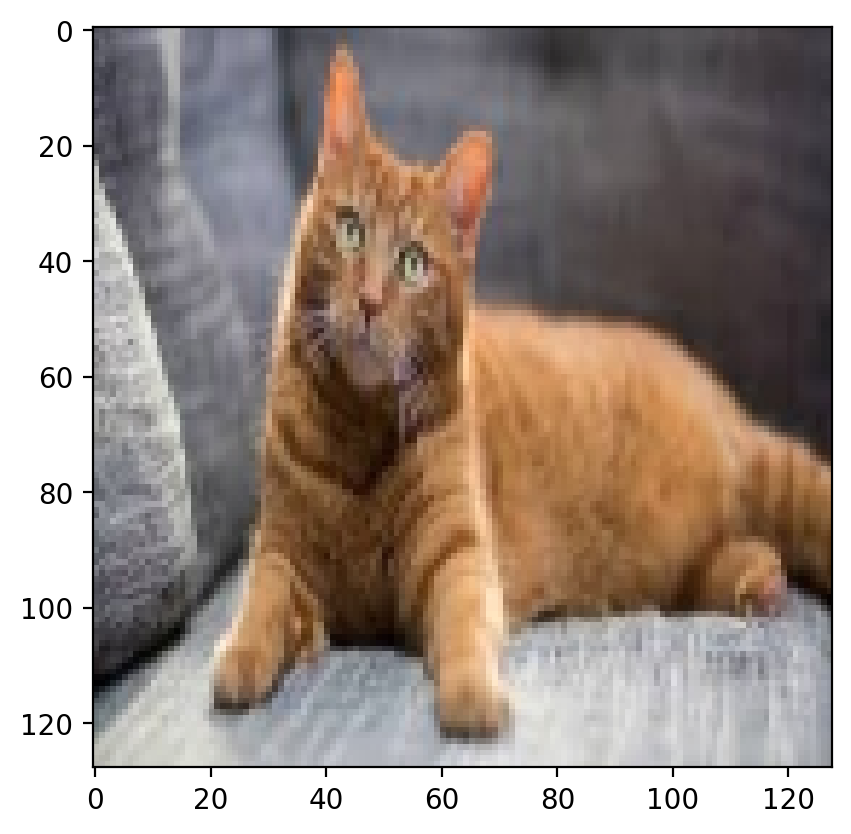

                             Query  Probability
0   the picture location is indoor     0.647949
1  the picture location is outdoor     0.352295
                                 Query  Probability
2  the picture dominant_color is green     0.480225
1    the picture dominant_color is red     0.340576
0   the picture dominant_color is blue     0.179443

Final inference dict:
-------------------------
{'location': 'indoor', 'dominant_color': 'green'}
-------------------------



In [6]:
example_files = glob('/content/DeepKeep/*.jpg')
show_examples(example_files)

# Part I

## Efficiency factors

1. Precalculate the tag_dict captions, embeddings, to save time at inference (can be viewed at ClipTagger.init_tagger_mappers)
2. Calculate the image embedding only once for all the queries(can be viewed at ClipTagger.inference_forward)
3. Using dataframe to vectorize the mapping process between label indices and label's text to form the final result at ClipTagger.inference_forward
4. Untracking gradients' grahps at inference while tracking only text embedding's gradients at training
5. defined a light training_forward function to maximize efficiency during training.
6. Create a DataLoader which can operate with higher num_workers>0 setting, the CPU handles data loading and preprocessing in parallel threads, allowing the GPU to focus solely on computation. This balances the workload between the CPU and GPU, leading to more efficient training.
7. For large datasets and complex transformations, having multiple workers can increase the throughput of data fed into the GPU, which in turn can lead to faster training iterations.

## Seperation criteria at inference

1. Ignore tags with high Entropy. $H(x) = -∑P(x)*log_n(x)$ while n is the amount of captions (T1, T2,..Tn)
2. max entropy is $log_n(n)=1$, min entropy is 0
3. Defined entropy confidence as threshold

## Initialize DataLoader

In [7]:
class ImageDataset(Dataset):
  """
   A custom dataset class for loading images from file paths and applying transformations.
  """
  def __init__(self, image_paths, transform):
      self.image_paths = image_paths
      self.transform = transform

  def __len__(self):
      return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    image = Image.open(image_path).convert("RGB")
    return self.transform(image).cuda()

### Download and extract COCO128.

In [8]:
%%capture
!wget https://github.com/ultralytics/assets/releases/download/v0.0.0/coco128.zip
!unzip /content/coco128.zip
coco_files_paths = glob('/content/coco128/images/train2017/*.jpg')

### Define DataLoader and validation examples

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, random_split

# Define parameters
batch_size = 10

val_images = 3
# Initialize dataset
train_files, val_files = coco_files_paths[val_images:], coco_files_paths[:val_images]

coco_dataset = ImageDataset(train_files, model.clip_preprocess)

# Create dataloaders
coco_train_dl = DataLoader(coco_dataset, batch_size=batch_size, shuffle=True)


## Perform inference on COCO-128 dataset using \__call\__
Changing entropy_threshold gives a different result

In [10]:
# For entropy=1 there is no filtering
model.entropy_threshold = 1

print("---------Entropy threshold {0} -----------\n".format(model.entropy_threshold))
for batch_idx, img_batch in enumerate(coco_train_dl):
  print("###### batch {0} ######".format(batch_idx+1))
  print(model(img_batch))

model.entropy_threshold = 0.5
print("\n---------Entropy threshold {0} -----------\n".format(model.entropy_threshold))

for batch_idx, img_batch in enumerate(coco_train_dl):
  print("###### batch {0} ######".format(batch_idx+1))
  print(model(img_batch))

---------Entropy threshold 1 -----------

###### batch 1 ######
[{'location': 'indoor', 'dominant_color': 'red'}, {'location': 'outdoor', 'dominant_color': 'green'}, {'location': 'indoor', 'dominant_color': 'red'}, {'location': 'indoor', 'dominant_color': 'red'}, {'location': 'outdoor', 'dominant_color': 'blue'}, {'location': 'outdoor', 'dominant_color': 'red'}, {'location': 'outdoor', 'dominant_color': 'red'}, {'location': 'indoor', 'dominant_color': 'red'}, {'location': 'indoor', 'dominant_color': 'blue'}, {'location': 'indoor', 'dominant_color': 'blue'}]
###### batch 2 ######
[{'location': 'outdoor', 'dominant_color': 'green'}, {'location': 'outdoor', 'dominant_color': 'blue'}, {'location': 'outdoor', 'dominant_color': 'red'}, {'location': 'outdoor', 'dominant_color': 'red'}, {'location': 'outdoor', 'dominant_color': 'green'}, {'location': 'indoor', 'dominant_color': 'red'}, {'location': 'indoor', 'dominant_color': 'red'}, {'location': 'outdoor', 'dominant_color': 'green'}, {'locati

# Part II

### Extra work - not included
1. Supervised COCO annotation (not included) to balance MarginLoss


I talked with Almog regarding this one

In [11]:

# !wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
# !unzip /content/annotations_trainval2017.zip -d /content/coco128_annotations

# print(files)

# # Load the labels from the file
# with open('/content/coco-labels/coco-labels-2014_2017.txt', 'r') as file:
#     labels = file.read().splitlines()

# # Create the mapping of class_id to label
# class_id_to_label = {i: label for i, label in enumerate(labels)}


In [12]:
# Incorporate coco annotations

# class COCO_dataset(dset.CocoCaptions):
#     def __init__(self, image_paths,ann_file,transform):
#       super().__init__(root=image_paths, annFile = ann_file, transform=transform)
#       self.image_paths = image_paths
#       self.transform = transform
#       self.files = glob("{0}/*.jpg".format(image_paths))

#     def __len__(self):
#       return len(self.files)

#     def __getitem__(self, idx):
#       image, annotation = super().__getitem__(idx)
#       return image, clip.tokenize(annotation[0])


# # Initialize Dataset and DataLoader
# coco_ds = COCO_dataset('/content/coco128/images/train2017',
#                        '/content/coco128_annotations/annotations/captions_train2017.json',
#                        clip_preprocess)

# batch_size = 16
# coco_dataloader = DataLoader(coco_ds, batch_size=batch_size, shuffle=False)

## Fine-Tune to enhance logit seperation

1. Using MultiMarginLoss to enhance the seperation between the logits.
2. The idea is the same like SVM margin maximization
3. Fine-tuning upon tag_dict with coco-128

The MultiMarginLoss function can be expressed as:

$$
\text{Loss}(x, y) = \sum_{i \ne y} \max \left(0, x_i - x_y + \text{margin}\right)
$$

where:
- $x$ is the vector of softmax class scores from the model.
- $y$ is the index of the correct class.
- $x_y$ is the softmax score of the correct class.
- $x_i$ is the softmax score of the incorrect class.
- ${margin}$ is a positive hyperparameter constant that specifies the minimum difference required between the score of the correct class and the scores of incorrect classes

### TODO - Fine Tune with with different loss
1. Rather than using supervised learning to balance the margin loss, consider incorporating the following loss function:

  $Loss = \alpha*(MarginLoss) + (1-\alpha)*(DistanceLoss)$

  $DistanceLoss = |E_1-E_i|$ with $E_1$ representing the initial text embedding (before training) and $E_i$ the text embedding at the $i^{th}$ epoch.

2. Measure the test dataset entropy for saving the best weights
3. Discuss about maybe to expand the embedding search space.





## Validation examples before training

Showing the tagging softmax upon 3 validation images

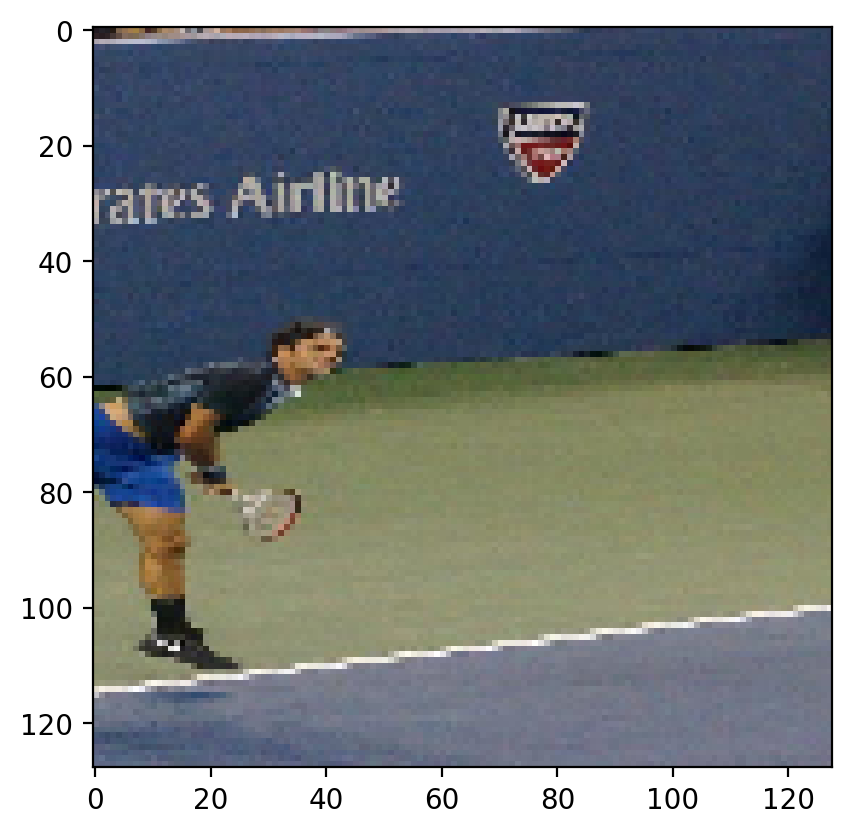

                             Query  Probability
0   the picture location is indoor     0.637207
1  the picture location is outdoor     0.363037
                                 Query  Probability
0   the picture dominant_color is blue     0.790527
1    the picture dominant_color is red     0.108704
2  the picture dominant_color is green     0.100525

Final inference dict:
-------------------------
{'location': 'indoor', 'dominant_color': 'blue'}
-------------------------



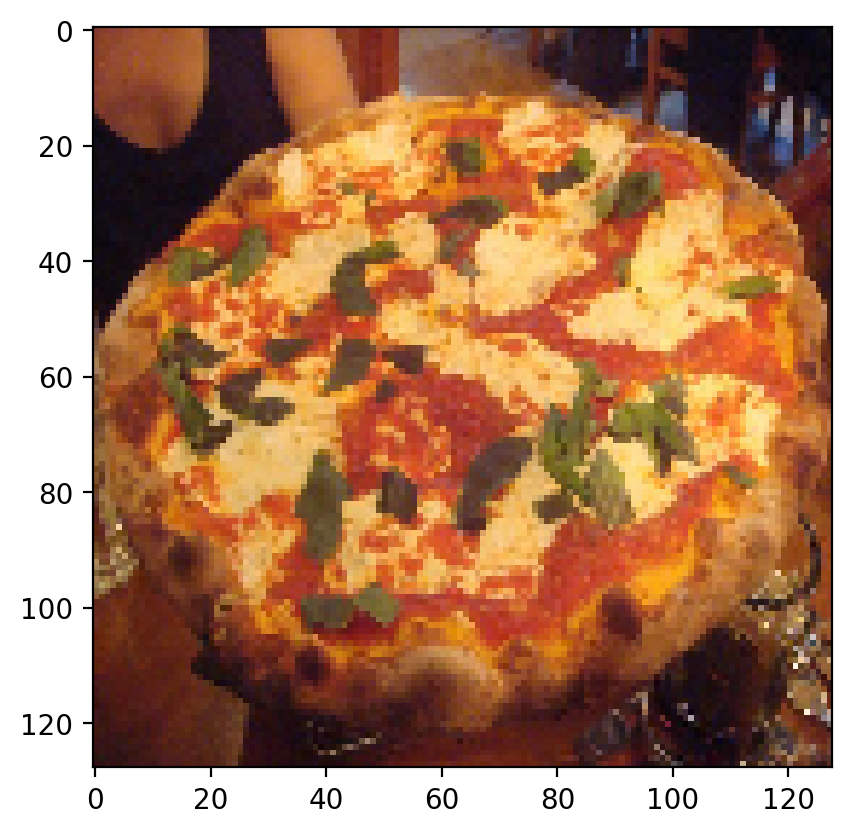

                             Query  Probability
1  the picture location is outdoor     0.565918
0   the picture location is indoor     0.434082
                                 Query  Probability
1    the picture dominant_color is red     0.492432
2  the picture dominant_color is green     0.317871
0   the picture dominant_color is blue     0.189819

Final inference dict:
-------------------------
{'location': 'outdoor', 'dominant_color': 'red'}
-------------------------



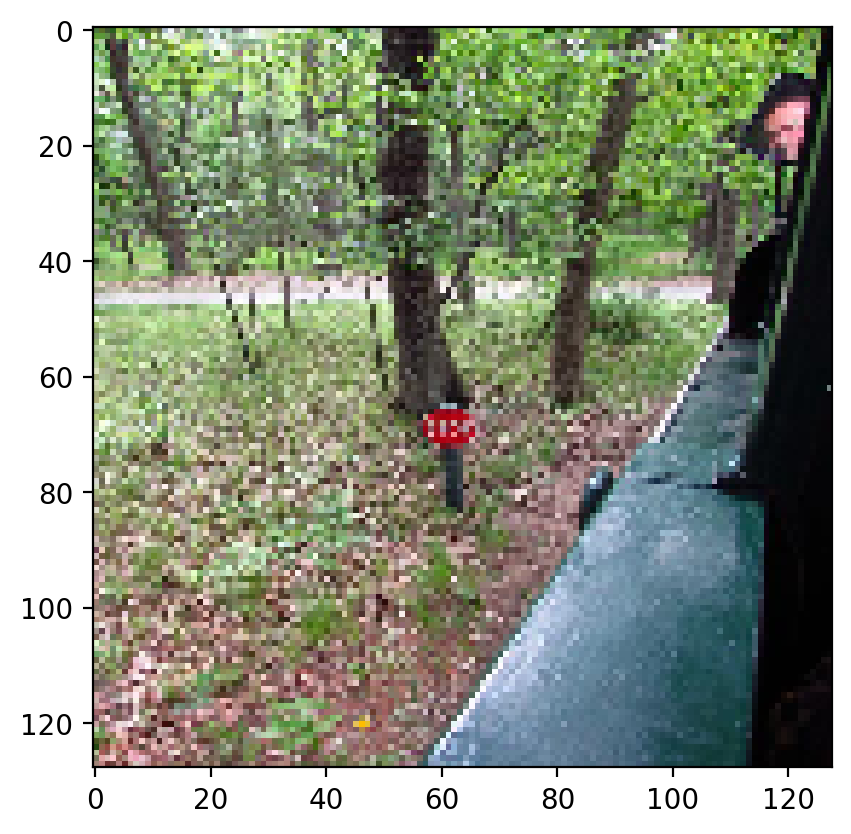

                             Query  Probability
1  the picture location is outdoor     0.980469
0   the picture location is indoor     0.019424
                                 Query  Probability
2  the picture dominant_color is green     0.684082
1    the picture dominant_color is red     0.259766
0   the picture dominant_color is blue     0.056152

Final inference dict:
-------------------------
{'location': 'outdoor', 'dominant_color': 'green'}
-------------------------



In [28]:
show_examples(val_files)

## Fine-tune the tagger to enhance logit seperation

In [38]:
# Define the training parameters
num_epochs =10
lr = 0.0000005

# Define loss and optimizer
cross_entropy_loss = torch.nn.CrossEntropyLoss()
margin_loss = torch.nn.MultiMarginLoss(margin=0.2)
optimizer = torch.optim.Adam(model.clip_model.parameters(), lr=lr)



def convert_models_to_fp32(model):
    # Converts the parameters and gradients of the given model to 32-bit floating point format (float32).
    # Avoid potential bug as mentioned in https://github.com/openai/CLIP/issues/57
    for p in model.parameters():
        p.data = p.data.float()
        if p.requires_grad:
          p.grad.data = p.grad.data.float()



def fune_tune_tagger():
  """
  Fine-tune the tagger's text encoder over a specified number of epochs to
  improve logits separation via MarginLoss optimization.

  The function performs:
    1. Freezes the visual transformer parameters to prevent their update.
    2. Encodes the image batch and normalizes image features for every set of queries
    3. For each epoch:
        - Computes logits using the text encoder.
        - Calculates probabilities and MarginLoss.
        - Performs backpropagation and updates the text encoder weights.

    Note: training.forward receives the tokens and not the embeddings since the goal
    is to find the best embeddings for a specifided token.
  """
  model.clip_model.train()
  # Freeze all the visual parameters, allowing optimizing only text encoder
  for param in model.clip_model.visual.parameters():
      param.requires_grad = False

  for epoch in range(num_epochs):
    model.clip_model.train()
    for i, images_batch in enumerate(tqdm(coco_train_dl, desc="Training", unit="batch")):

      # Encode image batch only once
      images_batch = images_batch.to(device)
      image_features = model.clip_model.encode_image(images_batch)
      image_features = image_features / image_features.norm(dim=1, keepdim=True)

      # Avoid calculating gradient for image features (only text encoder is being optimized)
      image_features.requires_grad = False

      for tag_subject, tag_value_tokens in model.query_token_map.items():

        # Zero the gradient before each training-forward
        optimizer.zero_grad()

        # Calculate probabilities and loss
        img_logits = model.training_forward(image_features, tag_value_tokens)
        Px = (img_logits).softmax(dim=-1)
        psuedo_label_y = torch.argmax(Px, dim=1)
        contrast_embedding_loss = margin_loss(Px, psuedo_label_y)

        # Perform backward propagation
        contrast_embedding_loss.backward()

        # Avoid https://github.com/openai/CLIP/issues/57
        convert_models_to_fp32(model)

        optimizer.step() # Update the text encoder weights
        clip.model.convert_weights(model)

    print(f"Epoch {epoch+1}/{num_epochs} completed.")

  # Since the encoder weights have changed, it is required to re-initalize
  # the embeddings mapper (model.query_emb_map property)
  model.init_tagger_mappers()


fune_tune_tagger()



Training: 100%|██████████| 13/13 [00:03<00:00,  4.33batch/s]


Epoch 1/10 completed.


Training: 100%|██████████| 13/13 [00:02<00:00,  5.70batch/s]


Epoch 2/10 completed.


Training: 100%|██████████| 13/13 [00:02<00:00,  5.67batch/s]


Epoch 3/10 completed.


Training: 100%|██████████| 13/13 [00:02<00:00,  5.72batch/s]


Epoch 4/10 completed.


Training: 100%|██████████| 13/13 [00:02<00:00,  5.61batch/s]


Epoch 5/10 completed.


Training: 100%|██████████| 13/13 [00:02<00:00,  4.33batch/s]


Epoch 6/10 completed.


Training: 100%|██████████| 13/13 [00:02<00:00,  5.27batch/s]


Epoch 7/10 completed.


Training: 100%|██████████| 13/13 [00:02<00:00,  5.67batch/s]


Epoch 8/10 completed.


Training: 100%|██████████| 13/13 [00:02<00:00,  5.60batch/s]


Epoch 9/10 completed.


Training: 100%|██████████| 13/13 [00:02<00:00,  5.77batch/s]

Epoch 10/10 completed.


## Validation examples after training
1. To avoid distortion of the embedding we need a balancing factor. I thought about 2 options:

  A. weighted sum of the supervised original loss and the contrast embedding loss

  B. Weighted sum with the distance loss as described above
  
3. To avoid distortion, I used few epochs and relative small step size just to perform "light" tuning without much distortion.

4. As shown, the logits seperation improved

TODO
1. The best practice is to divide to test,validation and train and measure the test dataset entropy before and after training


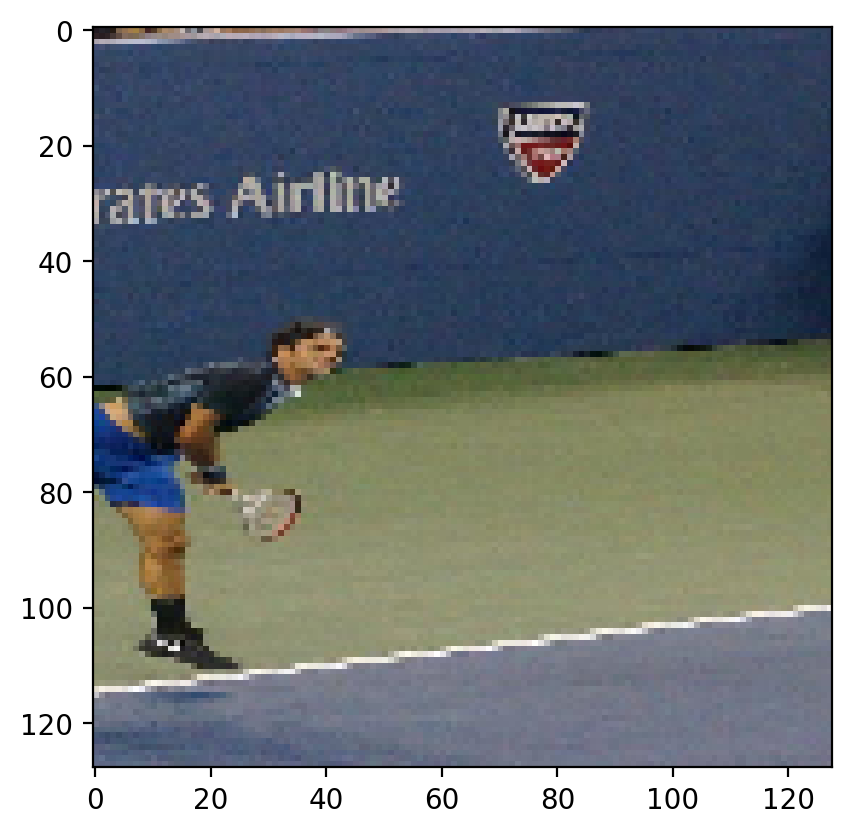

                             Query  Probability
0   the picture location is indoor     0.633301
1  the picture location is outdoor     0.366699
                                 Query  Probability
0   the picture dominant_color is blue     0.863770
1    the picture dominant_color is red     0.088257
2  the picture dominant_color is green     0.047974

Final inference dict:
-------------------------
{'location': 'indoor', 'dominant_color': 'blue'}
-------------------------



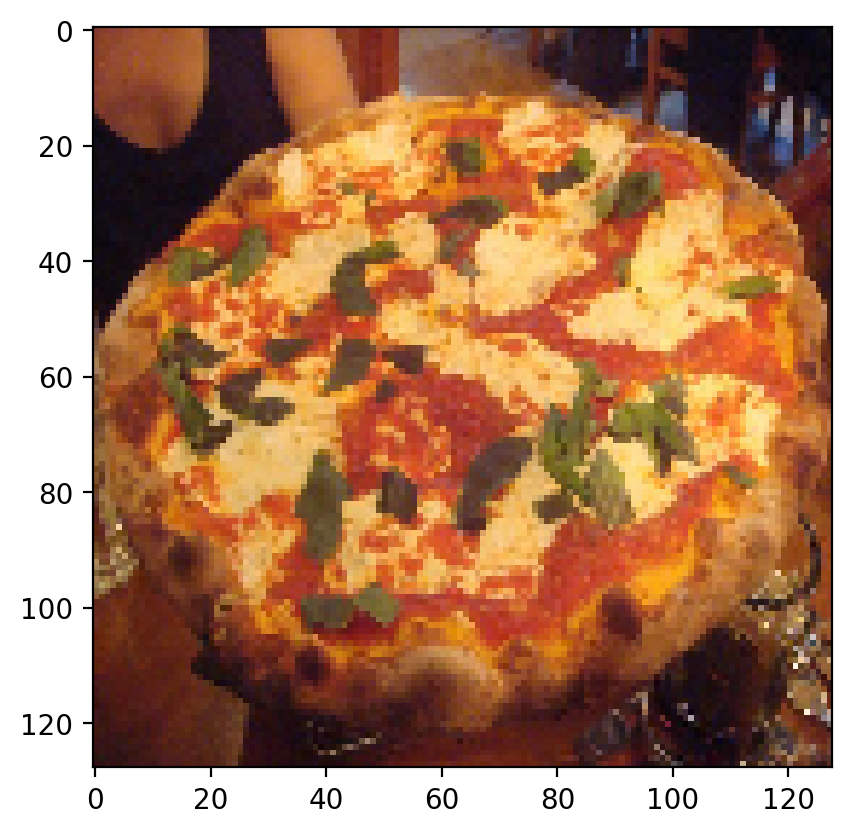

                             Query  Probability
0   the picture location is indoor     0.519531
1  the picture location is outdoor     0.480469
                                 Query  Probability
1    the picture dominant_color is red     0.628418
2  the picture dominant_color is green     0.210449
0   the picture dominant_color is blue     0.161377

Final inference dict:
-------------------------
{'location': 'indoor', 'dominant_color': 'red'}
-------------------------



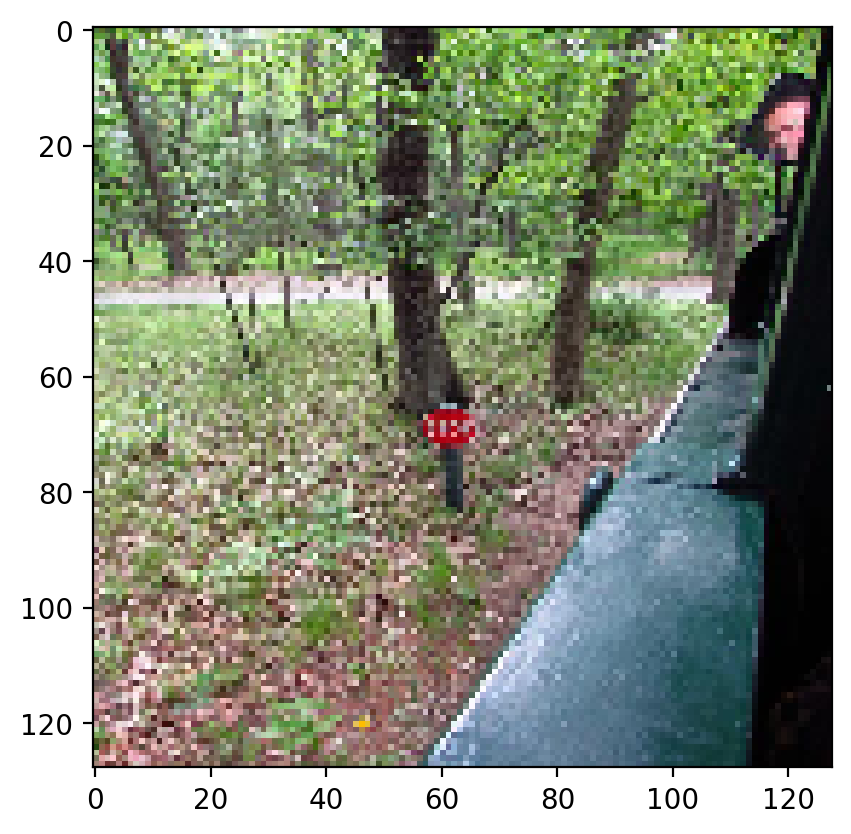

                             Query  Probability
1  the picture location is outdoor     0.986816
0   the picture location is indoor     0.013222
                                 Query  Probability
2  the picture dominant_color is green     0.746582
1    the picture dominant_color is red     0.231323
0   the picture dominant_color is blue     0.021851

Final inference dict:
-------------------------
{'location': 'outdoor', 'dominant_color': 'green'}
-------------------------



In [39]:
show_examples(val_files)

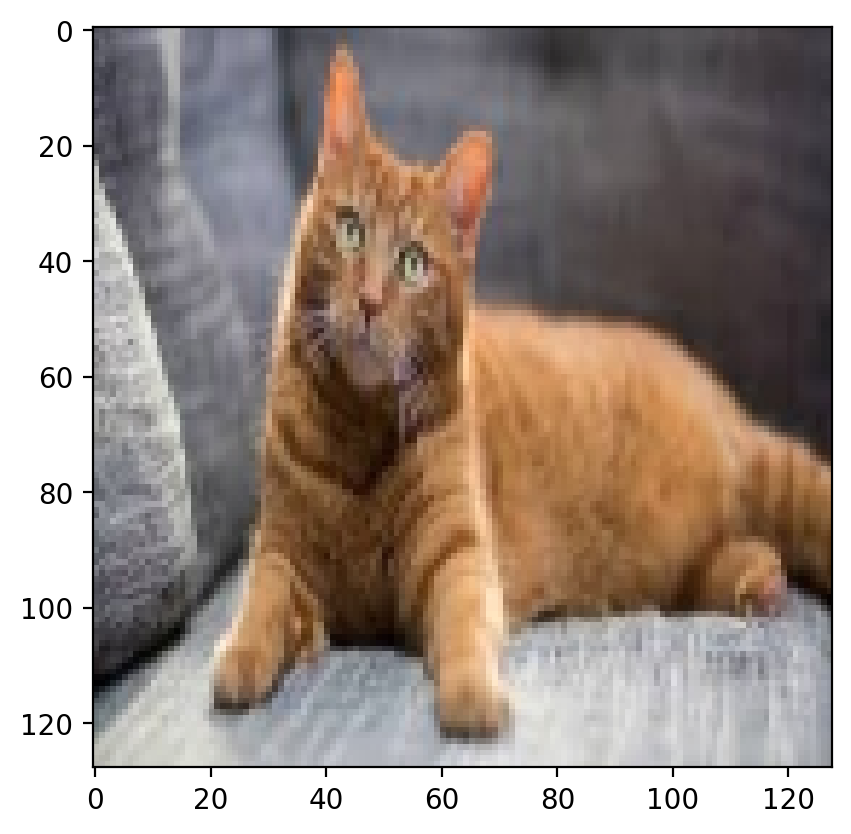

                             Query  Probability
0   the picture location is indoor     0.675781
1  the picture location is outdoor     0.324219
                                 Query  Probability
1    the picture dominant_color is red     0.430176
2  the picture dominant_color is green     0.404053
0   the picture dominant_color is blue     0.165771

Final inference dict:
-------------------------
{'location': 'indoor', 'dominant_color': 'red'}
-------------------------



In [40]:
show_examples(example_files)

### Supervised COCO annotation (not included)

I talked with Almog regarding this one

In [16]:
# Avoid embedding distortion with supervised learning

#images_batch, annotations_batch = batch[0].to(device), batch[1].to(device)

# Can add balancing factor via adding freezed embedding and minimize the
# distance from them

# alpha = torch.tensor(0.2)
# loss_i = cross_entropy_loss(img_logits, labels, axis=0)
# loss_t = cross_entropy_loss(img_logits, labels, axis=1)

# original_clip_loss = (loss_i + loss_t)/2
# total_loss = alpha*original_clip_loss + (1-alpha)*contrast_embedding_loss